In [23]:
# Initial imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

# Needed for visualisation
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
import pydotplus
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

## Loading and Preprocessing Loans Encoded Data

In [2]:
# Read the dataset file with the Pandas 
dataset_df = pd.read_csv("../Outputs/Employee_attrition.csv")

# Display the dataframe
dataset_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
# Encode categorical variables
for column in dataset_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_df[column] = le.fit_transform(dataset_df[column])
   

In [4]:
# Display the dataset after encoding
dataset_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2


In [5]:
# Define features set
X = dataset_df.copy()
X = X.drop(columns= ['Attrition'],axis=1)
X.head()


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,2,1102,2,1,2,1,2,0,94,...,3,1,0,8,0,1,6,4,0,5
1,49,1,279,1,8,1,1,3,1,61,...,4,4,1,10,3,3,10,7,1,7
2,37,2,1373,1,2,2,4,4,1,92,...,3,2,0,7,3,3,0,0,0,0
3,33,1,1392,1,3,4,1,4,0,56,...,3,3,0,8,3,3,8,7,3,0
4,27,2,591,1,2,1,3,1,1,40,...,3,4,1,6,3,3,2,2,2,2


In [6]:
# Define target vector
y = dataset_df['Attrition'].ravel()
y[:5]

array([1, 0, 1, 0, 0])

## Splitting the dataset

In [7]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Hyperparameters Tuning

In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [9]:
# Create a random forest classifier
random_forest_model = RandomForestClassifier(random_state=1)

In [10]:
# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [11]:
# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total t

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [12]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Score: 0.8638811554713107


## Creating optimal Random Forest model

In [13]:
# Creating optimal Random Forest model
optimized_random_forest_model = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    bootstrap = best_params['bootstrap'],
    random_state = 1
)

## Fitting Random Forest model

In [14]:
# Fitting the model
optimized_random_forest_model = optimized_random_forest_model.fit(X_train, y_train)

## Making Predictions Using the Random Forest Model

In [15]:
# Making predictions using the testing data
random_forest_predictions = optimized_random_forest_model.predict(X_test)

## Random Forest Evaluation

,Predicted 0,Predicted 1
Actual 0,295,5
Actual 1,61,7


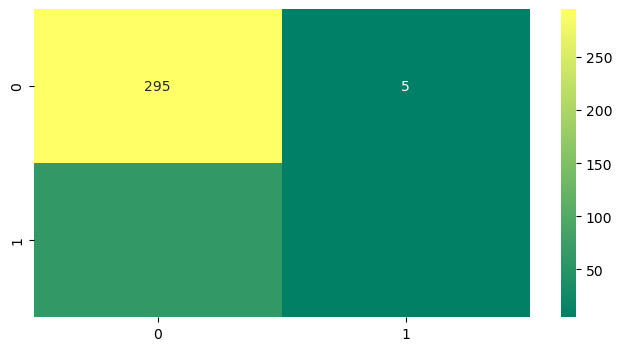

In [22]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, random_forest_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

display(cm_df)

plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="summer")

plt.savefig("../Outputs/random_forest_confusion_matrix.png")

plt.show()

In [17]:
# Calculating the accuracy score
random_forest_accuracy_score = accuracy_score(y_test, random_forest_predictions)

print(f"Accuracy Score is: {random_forest_accuracy_score}")


Accuracy Score is: 0.8206521739130435


In [18]:
# Classification Report
random_forest_clas_report = classification_report(y_test,  random_forest_predictions)

print("Classification Report")
print(random_forest_clas_report)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       300
           1       0.58      0.10      0.18        68

    accuracy                           0.82       368
   macro avg       0.71      0.54      0.54       368
weighted avg       0.78      0.82      0.77       368



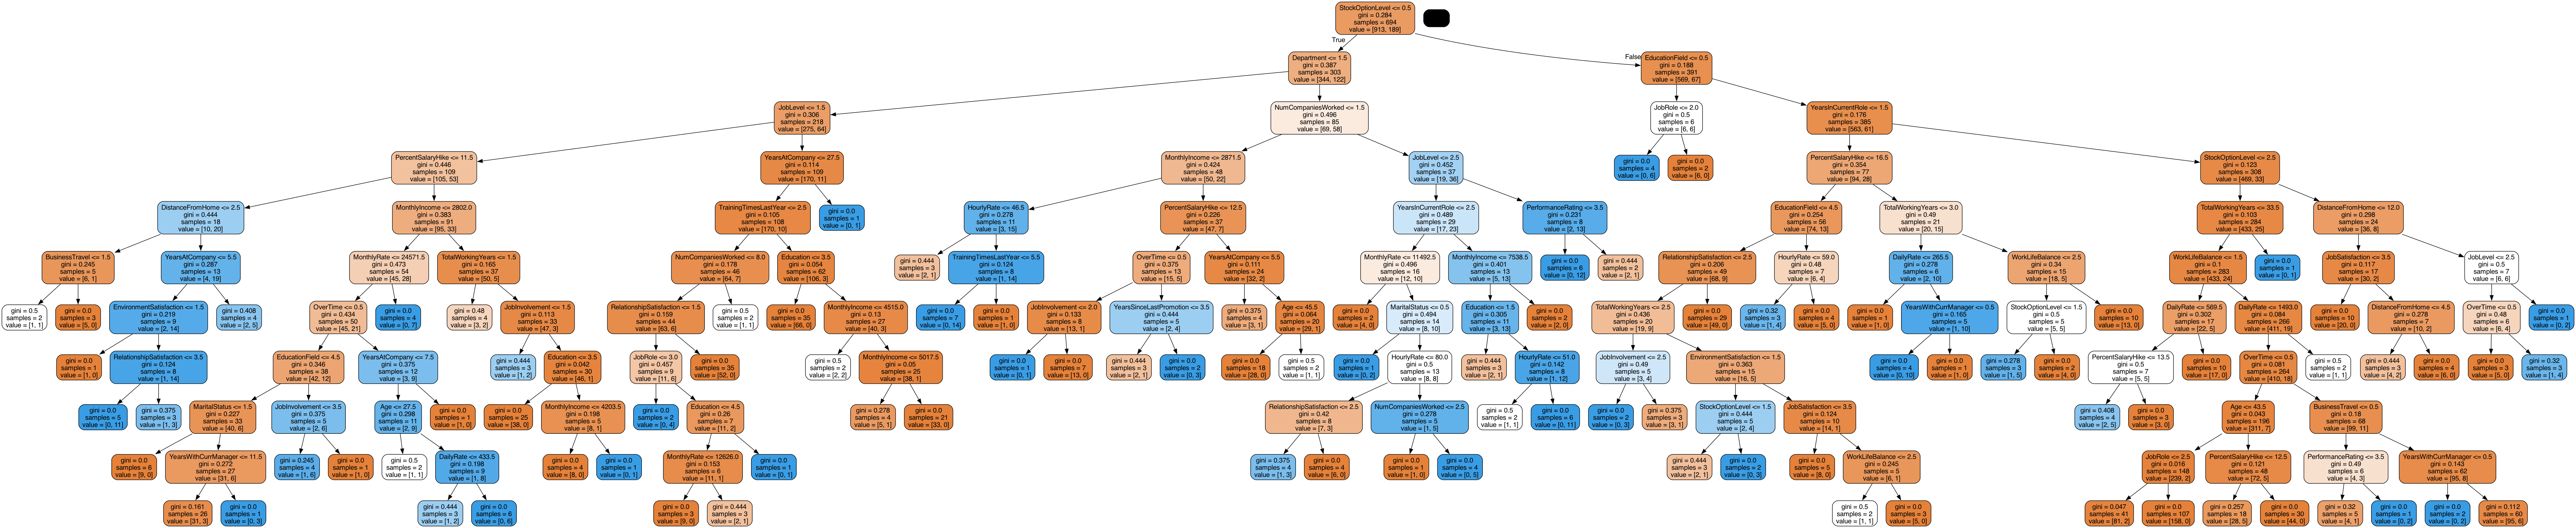

In [19]:
# Export as DOT file
estimator = optimized_random_forest_model.estimators_[1]
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train.columns, rounded=True, proportion=False, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = optimized_random_forest_model.feature_importances_
# We can sort the features by their importance
sorted(zip(optimized_random_forest_model.feature_importances_, X.columns), reverse=True)

[(0.0863943885936924, 'MonthlyIncome'),
 (0.06044580679545798, 'Age'),
 (0.05787363032345816, 'DailyRate'),
 (0.05556677999157731, 'OverTime'),
 (0.05515295373790835, 'DistanceFromHome'),
 (0.04821244539085844, 'TotalWorkingYears'),
 (0.04770104796567257, 'MonthlyRate'),
 (0.04571023961209877, 'YearsAtCompany'),
 (0.04253271379180313, 'HourlyRate'),
 (0.039524187031949376, 'JobRole'),
 (0.035130417758459875, 'StockOptionLevel'),
 (0.0342177457096583, 'YearsWithCurrManager'),
 (0.03358600505674543, 'PercentSalaryHike'),
 (0.03295847525086411, 'EnvironmentSatisfaction'),
 (0.030869413453826943, 'NumCompaniesWorked'),
 (0.02944452367754737, 'JobInvolvement'),
 (0.02742872761672707, 'EducationField'),
 (0.025828850103916317, 'MaritalStatus'),
 (0.0253877477538202, 'YearsSinceLastPromotion'),
 (0.023951809234456483, 'WorkLifeBalance'),
 (0.023944265444654812, 'TrainingTimesLastYear'),
 (0.02364424389628334, 'YearsInCurrentRole'),
 (0.020784066586846273, 'JobSatisfaction'),
 (0.0198614668222

<Axes: title={'center': 'Features Importances'}, ylabel='Features'>

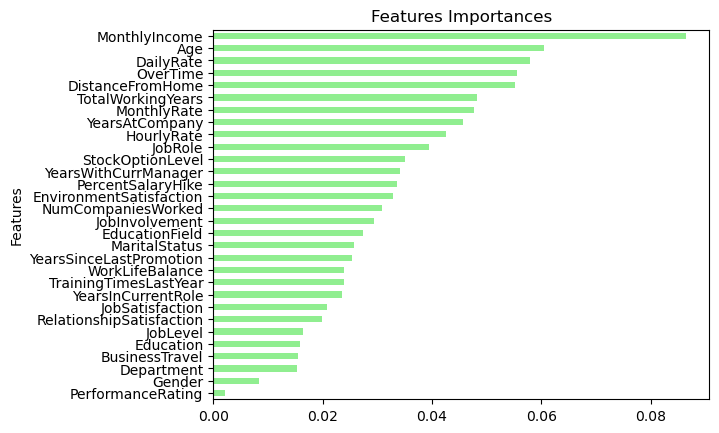

In [21]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(optimized_random_forest_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, ylabel='Features')

In [25]:
# Save the model
joblib.dump(optimized_random_forest_model, '../Outputs/random_forest_model.pkl')

['../Outputs/random_forest_model.pkl']